In [9]:
import importlib
import e7awgsw
import bokeh.io
import bokeh.plotting
import bokeh.models
import qubelsi.qube
import pickle
from IPython.display import clear_output
import numpy as np

import qubeui
import instruments

bokeh.plotting.output_notebook()

QUBE = 'Riken1'
QUBE_ID = 8

qube = qubelsi.qube.Qube(
    '10.5.0.26', # IP address of eXtickGE
    '/home/sio3/QuBE_Char/adi_api_mod', # Path to API
)
qubeui.StartupUI(qube)
visa = instruments.new_resource_manager()

Loading BokehJS ...

Text(value='10.5.0.26', description='IP Address for eXtickGE', disabled=True, style=DescriptionStyle(descripti…

Text(value='/home/sio3/QuBE_Char/adi_api_mod', description='Path to API', disabled=True, layout=Layout(width='…

Button(description='Do init', layout=Layout(height='80px', width='50%'), style=ButtonStyle())

Button(description='Restart AD9082', layout=Layout(height='80px', width='50%'), style=ButtonStyle())

# ↑ は初期化コードですので普段は使わないでください

---

# 周波数特性測定コード（粗測定）

In [17]:
#r = ms2038.measure()
# ADRF6780のVATTを変更しながらスペクトルを取得する
import pickle

PORT_ID = 2
VATT = 0xC00
TYPE = 'A'

port = qubeui.new_port_handler(qube)

if TYPE == 'A':
    qube.adrf6780[0].set_usb()
    qube.adrf6780[1].set_usb()
    qube.adrf6780[2].set_lsb()
    qube.adrf6780[3].set_lsb()
    qube.adrf6780[4].set_lsb()
    qube.adrf6780[5].set_lsb()
    qube.adrf6780[6].set_usb()
    qube.adrf6780[7].set_usb()
else:
    qube.adrf6780[0].set_lsb()
    qube.adrf6780[1].set_lsb()
    qube.adrf6780[2].set_lsb()
    qube.adrf6780[3].set_lsb()
    qube.adrf6780[4].set_lsb()
    qube.adrf6780[5].set_lsb()
    qube.adrf6780[6].set_lsb()
    qube.adrf6780[7].set_lsb()

ms2038 = instruments.MS2038_SPA(visa)
ms2038.write(':INIT:CONT OFF')

fname = 'Qube{}_{}_Port{}_{}_coarse.pickle'.format(QUBE, QUBE_ID, PORT_ID, hex(VATT))
result = []
# for FL in range(10400, 11001, 100): #元の設定
#    for FI in range(1800,3201,50): #元の設定

# Readout 9500 - 11000
#   IF 1300 - 2000
#   LO 8200 - 8500 

# 4/10に根来が追記
# def set_flo_fnco_according_to_frf_usb(lmx2594, frf, fif, apply=True): # MHz
#     flo = frf - fif
#     set_lmx2594_freq_100M(lmx2594, int(flo*1e-2))
#     if apply:
#         apply_lmx2594(lmx2594)
#     return flo

FL = 8200
FI = 1500

try:
    # FL = 8200
    # FI = 1800
    #for FL in range(10400, 11001, 200): # for CTRL
    #    for FI in range(1800,3201,200): # for CTRL
    #        FR = FL - FI
    #for FL in range(8200, 8501, 100): # for READOUT
    #    for FI in range(1300,2001,100): # for READOUT
    #        FR = FL - FI
    for FL in range(8200, 8301, 100): # for PUMP
        for FI in range(1500,1801,50): # for PUMP
            FR = FL - FI
            qubeui.set_flo_fnco_according_to_frf(port[PORT_ID], FR, FI)
            # set_flo_fnco_according_to_frf_usb(port[PORT_ID], FR, FI) # 4/11根来が追記
            qubeui.set_vatt(port[PORT_ID].upconv.vatt, VATT)
            measure = ms2038.measure()
            data = {
                'trace': measure.trace,
                'preamble': measure.preamble,
                'numpy_array': np.array([
                    instruments.MS2038_SPA.extract_frequency_array_from_preamble(measure.preamble),
                    instruments.MS2038_SPA.convert_trace_to_array(measure.trace),
                ]),
            }
            data['Qube'] = QUBE
            data['Qube ID'] = QUBE_ID
            data['Port ID'] = PORT_ID
            data['VATT'] = VATT
            data['IF'] = FI
            data['LO'] = FL
            data['AD9082 Current Mode'] = '(0x01B, 0x0F), (0x117, 0xA0), (0x118, 0xFF)'
            result.append(data)
            p = bokeh.plotting.figure(
                title='LO={}MHz, IF={}MHz, VATT={}'.format(FL, FI, hex(VATT)),
                height=300,
                toolbar_location=None,
                sizing_mode="stretch_width")
            p.line(data['numpy_array'][0,:],data['numpy_array'][1,:])
            clear_output()
            bokeh.plotting.show(p)
finally:
    with open(fname, 'wb') as f:
        pickle.dump(result, f)

# ↓　周波数特性測定コード（細密測定）

In [ ]:
#r = ms2038.measure()
# ADRF6780のVATTを変更しながらスペクトルを取得する
import pickle

PORT_ID = 7
VATT = 0xC00

port = qubeui.new_port_handler(qube)

ms2038 = instruments.MS2038_SPA(visa)
ms2038.write(':INIT:CONT OFF')

fname = 'Qube{}_{}_Port{}_{}.pickle'.format(QUBE, QUBE_ID, PORT_ID, hex(VATT))
result = []
# FL = 10400
# FI = 1800
# for FL in range(10400, 11001, 100): #元の設定
#    for FI in range(1800,3201,50): #元の設定
try:
    for FL in range(10400, 11001, 100):
        for FI in range(1800,3201,50):
            FR = FL - FI
            qubeui.set_flo_fnco_according_to_frf(port[PORT_ID], FR, FI)
            qubeui.set_vatt(port[PORT_ID].upconv.vatt, VATT)
            data = ms2038.measure()
            data['Qube'] = QUBE
            data['Qube ID'] = QUBE_ID
            data['Port ID'] = PORT_ID
            data['VATT'] = VATT
            data['IF'] = FI
            data['LO'] = FL
            data['AD9082 Current Mode'] = '(0x01B, 0x0F), (0x117, 0xA0), (0x118, 0xFF)'
            result.append(data)
            p = bokeh.plotting.figure(
                title='LO={}MHz, IF={}MHz, VATT={}'.format(FL, FI, hex(VATT)),
                height=300,
                toolbar_location=None,
                sizing_mode="stretch_width")
            p.line(data['numpy_array'][0,:],data['numpy_array'][1,:])
            clear_output()
            bokeh.plotting.show(p)
finally:
    with open(fname, 'wb') as f:
        pickle.dump(result, f)

In [77]:
from collections import namedtuple

Vatt = namedtuple('Vatt', ('dac', 'ch'))
Upconv = namedtuple('Upconv', ('vatt',))
Ifdac = namedtuple('Ifdac', ('ad9082', 'ch'))
CtrlPort = namedtuple('CtrlPort', ('losc', 'ifdac', 'upconv'))

port = {
    5 : CtrlPort(qube.lmx2594[2], Ifdac(qube.ad9082[0], 2), Upconv(Vatt(qube.ad5328, 2))), # CTRL1
    6 : CtrlPort(qube.lmx2594[3], Ifdac(qube.ad9082[0], 3), Upconv(Vatt(qube.ad5328, 3))), # CTRL2
    7 : CtrlPort(qube.lmx2594[4], Ifdac(qube.ad9082[1], 0), Upconv(Vatt(qube.ad5328, 4))), # CTRL3
    8 : CtrlPort(qube.lmx2594[5], Ifdac(qube.ad9082[1], 1), Upconv(Vatt(qube.ad5328, 5))), # CTRL4
}

def apply_vatt(ad5328):
    ad5328.write_value(0xA, 0x002)
    return True

def set_vatt(vatt, v, apply=True): # max 4095
    vatt.dac.write_value(vatt.ch, v)
    if apply:
        apply_vatt(vatt.dac)
    return v/0xfff*3.3

# set_vatt(port[5].upconv.vatt, 0xA00)
# set_vatt(port[6].upconv.vatt, 0xA00)
set_vatt(port[7].upconv.vatt, 0xC00)
# set_vatt(port[8].upconv.vatt, 0xC00)
qubeui.set_flo_fnco_according_to_frf(port[7], 11000-2400, 2400)

(11000, 2397.5)

In [38]:
0xc90/0xfff*3.3

2.5916483516483515

-2.392

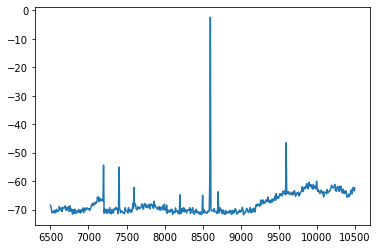

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

ms2038.write(':INIT:CONT OFF')
data = ms2038.measure()
a = np.array([
    ms2038.extract_frequency_array_from_preamble(data['preamble']),
    ms2038.convert_trace_to_array(data['trace'])
])
plt.plot(a[0],a[1])
max(a[1])

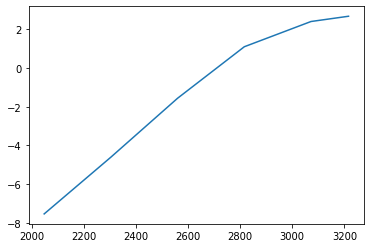

In [74]:
# 出力特性 (VATT vs Pout @ QuBE Riken #1-5 Port 7)

a = np.array([
    [0x800, -7.54],
    [0x900, -4.608],
    [0xa00, -1.564],
    [0xb00, 1.096],
    [0xc00, 2.4],
    [0xc90, 2.672],
])
plt.plot(a[:,0], a[:,1])

In [ ]:
#r = ms2038.measure()
# ADRF6780のVATTを変更しながらスペクトルを取得する
import pickle

PORT_ID = 8

port = qubeui.new_port_handler(qube)

ms2038 = instruments.MS2038_SPA(visa)
ms2038.write(':INIT:CONT OFF')

fname = 'Qube{}_{}_Port{}_coarse_0xC00.pickle'.format(QUBE, QUBE_ID, PORT_ID)
result = []
# FL = 10400
# FI = 1800
# for FL in range(10400, 11001, 100): #元の設定
#    for FI in range(1800,3201,50): #元の設定
for FL in range(10400, 11001, 200):
    for FI in range(1800,3201,200):
        FR = FL - FI
        qubeui.set_flo_fnco_according_to_frf(port[PORT_ID], FR, FI)
        qubeui.set_vatt(port[PORT_ID].upconv.vatt, 0xC00)
        data = ms2038.measure()
        data['Qube'] = QUBE
        data['Qube ID'] = QUBE_ID
        data['Port ID'] = PORT_ID
        data['VATT'] = 0xC00
        data['IF'] = FI
        data['LO'] = FL
        data['AD9082 Current Mode'] = '(0x01B, 0x0F), (0x117, 0xA0), (0x118, 0xFF)'
        result.append(data)
        p = bokeh.plotting.figure(height=300, toolbar_location=None, sizing_mode="stretch_width")
        p.line(data['numpy_array'][0,:],data['numpy_array'][1,:])
        clear_output()
        bokeh.plotting.show(p)
with open(fname, 'wb') as f:
    pickle.dump(result, f)    